# Comparing datasets over California

Within the state of California we can compare our risk estimates with estimates from two other datasets: (1) the Wildfire Risk to Communities project (as in the other comparison notebook attached to this project) and the [California Fire Hazard Severity Zones](https://osfm.fire.ca.gov/what-we-do/community-wildfire-preparedness-and-mitigation/fire-hazard-severity-zones). This notebook contains those comparisons.

In [1]:
from itertools import combinations

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pandas as pd
import xarray as xr
from scipy.stats import kendalltau

from ocr import catalog

In [2]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
ca = states[states['STUSPS'].isin(['CA'])]

census_tracts_df = (
    catalog.get_dataset('us-census-tracts')
    .query_geoparquet(
        "SELECT GEOID, NAME, ST_AsText(geometry) as geometry, bbox FROM read_parquet('{s3_path}')"
    )
    .df()
)
census_tracts = gpd.GeoDataFrame(
    census_tracts_df, geometry=gpd.GeoSeries.from_wkt(census_tracts_df['geometry'])
)

ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_22628/2343889974.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]


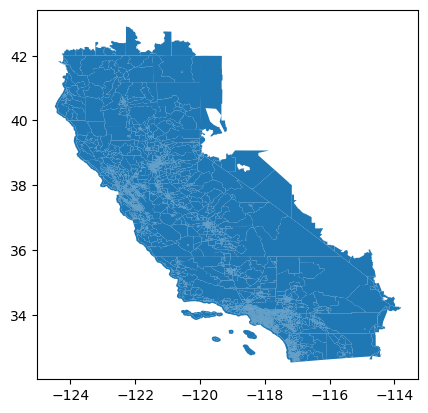

In [3]:
ca_census_tracts.plot();

In [4]:
import duckdb

duckdb.sql("""INSTALL SPATIAL; LOAD SPATIAL; INSTALL HTTPFS; LOAD HTTPFS""")

version = 'v1.1.0'
dataset_uri = f's3://carbonplan-ocr/output/fire-risk/vector/production/{version}/geoparquet/buildings.parquet/**/data_*.parquet'

CA_FIPS_CODE = '06'

In [5]:
%%time

df = duckdb.sql(f"""
SELECT
    * EXCLUDE (geometry),
    ST_AsText(geometry) as geometry
FROM
   read_parquet('{dataset_uri}')

WHERE
   state_fips = '{CA_FIPS_CODE}'

""").df()

gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf.head()

CPU times: user 1min 45s, sys: 10.4 s, total: 1min 56s
Wall time: 1min 15s


,rps_scott,rps_2011,rps_2047,bp_2011,bp_2047,crps_scott,bp_2011_riley,bp_2047_riley,GEOID,state,county,bbox,county_fips,state_fips,geometry
0,0.000000,0.000000,0.000000,0.000002,0.000004,0.000000,0.0,0.0,060014415211001,CA,Alameda County,"{'xmin': -122.0476453, 'ymin': 37.5756873, 'xm...",001,06,"POLYGON ((-122.04765 37.57574, -122.04763 37.5..."
1,0.011878,0.026289,0.040198,0.001351,0.002065,19.465267,0.0,0.0,060014351023005,CA,Alameda County,"{'xmin': -122.0476644, 'ymin': 37.6549031, 'xm...",001,06,"POLYGON ((-122.04763 37.65501, -122.04766 37.6..."
2,0.003546,0.004661,0.004874,0.000189,0.000198,24.618183,0.0,0.0,060014415242000,CA,Alameda County,"{'xmin': -122.0476046, 'ymin': 37.5564995, 'xm...",001,06,"POLYGON ((-122.04757 37.55654, -122.0476 37.55..."
3,0.014879,0.043608,0.070258,0.001580,0.002545,27.601515,0.0,0.0,060014301011025,CA,Alameda County,"{'xmin': -122.0476457, 'ymin': 37.6973006, 'xm...",001,06,"POLYGON ((-122.04757 37.69742, -122.04765 37.6..."
4,0.068422,0.056478,0.071107,0.002291,0.002884,24.655413,0.0,0.0,060014351041009,CA,Alameda County,"{'xmin': -122.0476435, 'ymin': 37.6321136, 'xm...",001,06,"POLYGON ((-122.04763 37.63218, -122.04764 37.6..."


In [6]:
ca_buildings = gdf.loc[gdf.geometry.intersects(ca.union_all())]
ca_buildings.shape, gdf.shape

((13687449, 15), (13712454, 15))

In [7]:
scott = catalog.get_dataset('scott-et-al-2024-30m-4326').to_xarray()

In [8]:
%%time
ds_reprojected = catalog.get_dataset('calfire-fhsz-4326').to_xarray()

# get building coords
coords = np.column_stack([ca_buildings.geometry.centroid.x, ca_buildings.geometry.centroid.y])

# extract hazard for buildings
building_hazard = ds_reprojected.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

CPU times: user 16.1 s, sys: 644 ms, total: 16.8 s
Wall time: 17.2 s


In [9]:
building_hazard_scott = scott.BP.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

In [10]:
%%time
# cast all nulls to zeros. areas with zero are considered without hazard in the cal fire approach
# and by casting them to zero we make them have a lower value than the non-zero values which
# prepares the data for a ranked test like kendall-tau
building_hazard = xr.where(building_hazard.band_data.isnull(), 0, building_hazard.band_data)
ca_buildings['cal-fire-hazard-zone'] = building_hazard.values[0]
ca_buildings['scott-bp'] = building_hazard_scott.values

ca_buildings_in_census_tracts = gpd.sjoin(ca_buildings, ca_census_tracts[['GEOID', 'geometry']])
ca_buildings_in_census_tracts.head()

CPU times: user 4min 24s, sys: 6.74 s, total: 4min 30s
Wall time: 4min 20s


,rps_scott,rps_2011,rps_2047,bp_2011,bp_2047,crps_scott,bp_2011_riley,bp_2047_riley,GEOID_left,state,county,bbox,county_fips,state_fips,geometry,cal-fire-hazard-zone,scott-bp,index_right,GEOID_right
0,0.000000,0.000000,0.000000,0.000002,0.000004,0.000000,0.0,0.0,060014415211001,CA,Alameda County,"{'xmin': -122.0476453, 'ymin': 37.5756873, 'xm...",001,06,"POLYGON ((-122.04765 37.57574, -122.04763 37.5...",0.0,0.000000,4191,06001441521
1,0.011878,0.026289,0.040198,0.001351,0.002065,19.465267,0.0,0.0,060014351023005,CA,Alameda County,"{'xmin': -122.0476644, 'ymin': 37.6549031, 'xm...",001,06,"POLYGON ((-122.04763 37.65501, -122.04766 37.6...",0.0,0.000610,10090,06001435102
2,0.003546,0.004661,0.004874,0.000189,0.000198,24.618183,0.0,0.0,060014415242000,CA,Alameda County,"{'xmin': -122.0476046, 'ymin': 37.5564995, 'xm...",001,06,"POLYGON ((-122.04757 37.55654, -122.0476 37.55...",0.0,0.000144,11499,06001441524
3,0.014879,0.043608,0.070258,0.001580,0.002545,27.601515,0.0,0.0,060014301011025,CA,Alameda County,"{'xmin': -122.0476457, 'ymin': 37.6973006, 'xm...",001,06,"POLYGON ((-122.04757 37.69742, -122.04765 37.6...",0.0,0.000539,6279,06001430101
4,0.068422,0.056478,0.071107,0.002291,0.002884,24.655413,0.0,0.0,060014351041009,CA,Alameda County,"{'xmin': -122.0476435, 'ymin': 37.6321136, 'xm...",001,06,"POLYGON ((-122.04763 37.63218, -122.04764 37.6...",0.0,0.002775,4889,06001435104


In [9]:
%%time
path = f's3://carbonplan-ocr/evaluation/comparisons/buildings-tracts-california-{version}.parquet'
ca_buildings_in_census_tracts.to_parquet(path)

CPU times: user 26.1 s, sys: 1.53 s, total: 27.6 s
Wall time: 26.2 s


## Load in CAL FIRE hazard layer

Note: The CAL FIRE hazard data is very clear that they do not estimate risk, which assesses the level of damage that a fire could cause. The main statistic we use in this analysis is a rank test called the Kendall's Tau which tests for concordance of data, asking: how similarly do two datasets rank areas on a scale from low to high? In other words, given two locations, do the two datasets agree which is higher or lower on a given scale? To do this comparison we assume that it makes sense for the fire hazard scales from CAL FIRE and the fire risk to potential structures scale from our datasets can be compared and that high numbers on either scale come from similar causes. We think this is a reasonable assumption given the similar attributes that each modeling system ingests: high-resolution vegetation maps, dynamic fire model, wind.

In [11]:
def apply_kendall_tau(x, y, variant):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant=variant)
    return pd.Series({f'tau_{variant}': tau, f'p_value_{variant}': p_value})

In [12]:
ca_buildings_in_census_tracts = ca_buildings_in_census_tracts.rename(
    {'GEOID_right': 'GEOID'}, axis=1
)

In [13]:
ds_name_dict = {
    'CarbonPlan': 'rps_2011',
    'Scott (2024)': 'rps_scott',
    'CAL FIRE': 'cal-fire-hazard-zone',
}

In [14]:
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']]

for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_kendall_tau(g[ds_name_dict[ds1_name]], g[ds_name_dict[ds2_name]], 'c')
    )
    new_df.columns = [f'{ds1_name} - {ds2_name} {column_name}' for column_name in new_df.columns]
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
# tract_performance_stats.to_parquet(
#     f's3://carbonplan-ocr/evaluation/comparisons/california-tract-stats-{version}.parquet'
# )

/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)


In [15]:
variable_name_dict = {
    'tau_c': "Kendall's Tau (c-variant) of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'rps_2047_median': 'CP median RPS',
    'rps_scott_median': 'WRC median RPS',
    'rps_2011_mean': 'CP mean RPS',
    'rps_scott_mean': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {
    'tau_c': [-1, 1],
    'bias': [-0.1, 0.1],
    'normalized_bias': [-1, 1],
    'corr': [-1, 1],
}

cmaps = {
    'tau_c': 'PRGn',
    'bias': 'RdBu_r',
    'normalized_bias': 'RdBu_r',
    'corr': 'PRGn',
}

When we calculate the concordance of our data with that of CAL FIRE for all census tracts in California, we see that typically the Kendall's Tau is above zero, indicating some concordance.

Text(0.5, 1.0, "Kendall's Tau of three fire datasets")

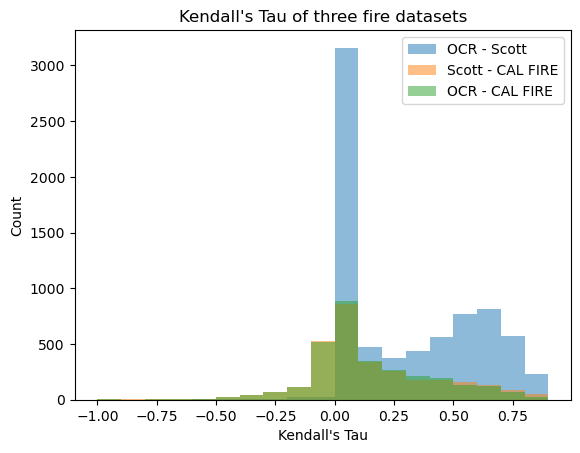

In [16]:
plt.hist(
    tract_performance_stats['CarbonPlan - Scott (2024) tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='OCR - Scott',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['Scott (2024) - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='Scott - CAL FIRE',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['CarbonPlan - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='OCR - CAL FIRE',
    alpha=0.5,
)

plt.legend()
plt.xlabel("Kendall's Tau")
plt.ylabel('Count')
plt.title("Kendall's Tau of three fire datasets")

In [17]:
variable = 'tau_c'
for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    print(
        f'{ds1_name} - {ds2_name} {variable} : {tract_performance_stats[f"{ds1_name} - {ds2_name} {variable}"].mean()}'
    )

CarbonPlan - Scott (2024) tau_c : 0.29881577659214176
CarbonPlan - CAL FIRE tau_c : 0.15059476565178315
Scott (2024) - CAL FIRE tau_c : 0.15728385400178554


Plotting the data across the state we see areas of higher concordance tend to cluster in smaller tracts in more developed areas.

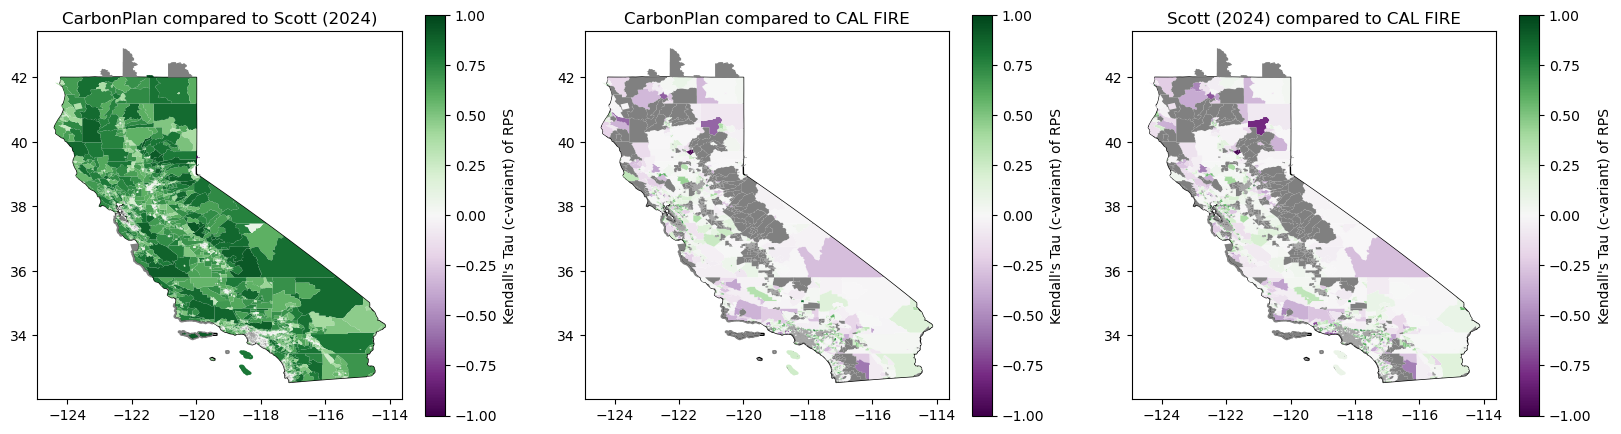

In [18]:
for variable in ['tau_c']:
    fig, axarr = plt.subplots(ncols=3, figsize=(20, 8))
    for i, (ds1_name, ds2_name) in enumerate(combinations(ds_name_dict.keys(), 2)):
        ca.plot(ax=axarr[i], color='white', edgecolor='black')
        ax = tract_performance_stats.plot(
            ax=axarr[i],
            column=f'{ds1_name} - {ds2_name} {variable}',
            vmin=var_lims[variable][0],
            vmax=var_lims[variable][1],
            legend=True,
            cmap=cmaps[variable],
            legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
        )
        tract_performance_stats[
            tract_performance_stats[f'{ds1_name} - {ds2_name} {variable}'].isnull()
        ].plot(ax=axarr[i], color='grey')
        axarr[i].set_title(f'{ds1_name} compared to {ds2_name}')

## Repeat the analysis for BP instead of RPS

In [19]:
ds_name_dict = {
    'CarbonPlan': 'bp_2011',
    'Scott (2024)': 'scott-bp',
    'CAL FIRE': 'cal-fire-hazard-zone',
}

In [20]:
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']]

for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_kendall_tau(g[ds_name_dict[ds1_name]], g[ds_name_dict[ds2_name]], 'c')
    )
    new_df.columns = [f'{ds1_name} - {ds2_name} {column_name}' for column_name in new_df.columns]
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')

/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_22628/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)


Text(0.5, 1.0, "Kendall's Tau of three fire datasets")

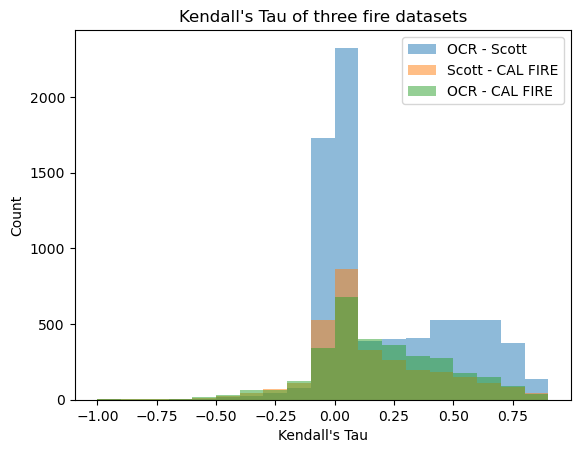

In [21]:
plt.hist(
    tract_performance_stats['CarbonPlan - Scott (2024) tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='OCR - Scott',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['Scott (2024) - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='Scott - CAL FIRE',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['CarbonPlan - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='OCR - CAL FIRE',
    alpha=0.5,
)

plt.legend()
plt.xlabel("Kendall's Tau")
plt.ylabel('Count')
plt.title("Kendall's Tau of three fire datasets")

In [22]:
variable = 'tau_c'
for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    print(
        f'{ds1_name} - {ds2_name} {variable} : {tract_performance_stats[f"{ds1_name} - {ds2_name} {variable}"].mean()}'
    )

CarbonPlan - Scott (2024) tau_c : 0.20627558615295866
CarbonPlan - CAL FIRE tau_c : 0.1914857192770855
Scott (2024) - CAL FIRE tau_c : 0.1536217508424281


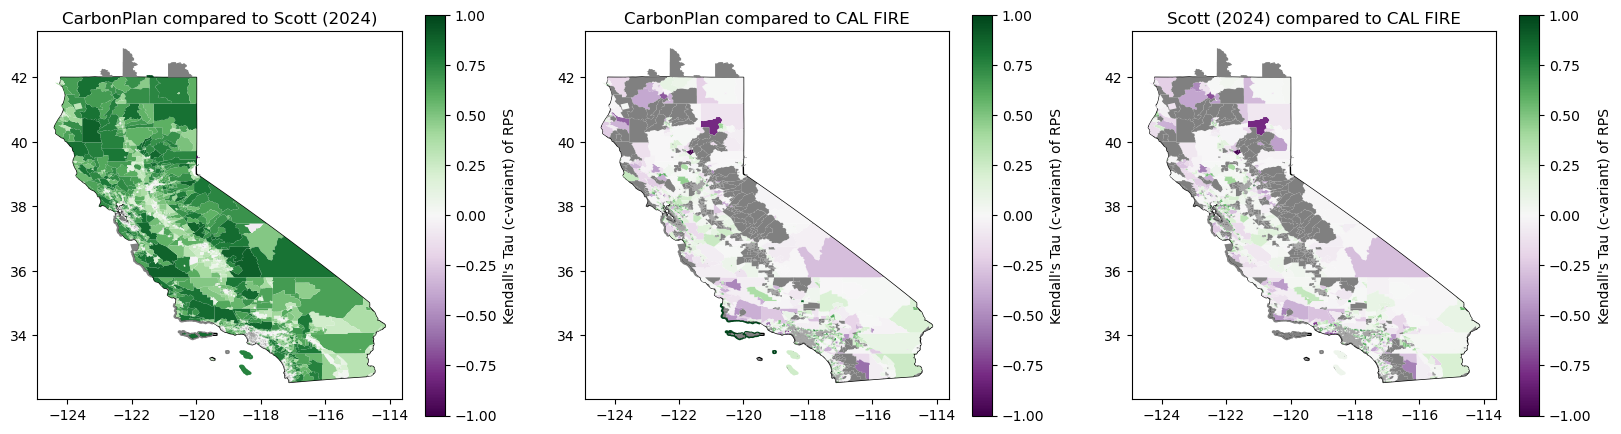

In [23]:
for variable in ['tau_c']:
    fig, axarr = plt.subplots(ncols=3, figsize=(20, 8))
    for i, (ds1_name, ds2_name) in enumerate(combinations(ds_name_dict.keys(), 2)):
        ca.plot(ax=axarr[i], color='white', edgecolor='black')
        ax = tract_performance_stats.plot(
            ax=axarr[i],
            column=f'{ds1_name} - {ds2_name} {variable}',
            vmin=var_lims[variable][0],
            vmax=var_lims[variable][1],
            legend=True,
            cmap=cmaps[variable],
            legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
        )
        tract_performance_stats[
            tract_performance_stats[f'{ds1_name} - {ds2_name} {variable}'].isnull()
        ].plot(ax=axarr[i], color='grey')
        axarr[i].set_title(f'{ds1_name} compared to {ds2_name}')